In [8]:
import pathlib
from shapely.geometry import MultiPolygon
from shapely.affinity import translate
from papermodels.paper import annotations, fdf, plot
import matplotlib.pyplot as plt


import xlwings as xw
import pandas as pd
import matplotlib.pyplot as plt


from __future__ import annotations
from dataclasses import dataclass
import json
from typing import Any, Union, Optional
from papermodels.paper import annotations, fdf, plot
from papermodels.db.data_model import Annotation
from shapely.geometry import GeometryCollection, Polygon, Point
from shapely.ops import voronoi_diagram
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from shapely import wkt, voronoi_polygons


# Constants
DEFAULT_WALL_HEIGHT = 3.0  # Default height for all walls (in meters)
FDF_FILE = 'Roof_data_r9.fdf'  # FDF file for wall data
ROOF_WEIGHT_PER_AREA = 2.9  # Weight per unit area of the roof diaphragm (kPa)

# Functions
def load_annotations(file_list: list[str], scale_factor: Optional[float] = None, labels: Optional[list[str]] = None) -> dict[str, list[Annotation]]:
    
    """
    Returns a dict whose keys are each file name in 'file_list' and values are a list
    of annotations found in the files. If 'scale_factor' is specified, the resulting
    annotation geometries are scaled by 'scale_factor'.
    'labels' - Labels to be used as dict keys for each file in 'file_list'
    
    """
    annot_data = {}
    for idx, file_name in enumerate(file_list):
        annots = fdf.read_annotations(file_name)
        if scale_factor is not None:
            annots = annotations.scale_annotations(annots, scale=scale_factor)
        if labels is not None:
            if len(labels) != len(file_list):
                raise ValueError(f"Length of labels must match length file list. {len(file_list)=}, {len(labels)=}")
            annot_data.update({labels[idx]: annots})
    return annot_data


def read_walls_from_fdf(fdf_file, line_weight_ns=2.0, line_weight_ew=3.0):
    """
    Reads wall data from an FDF file and separates them into NS and EW walls.
    
    Parameters:
    - fdf_file: Path to the FDF file.
    - line_weight_ns: Line weight for north-south walls.
    - line_weight_ew: Line weight for east-west walls.
    
    Returns:
    - ns_walls: List of NS wall data (lengths, x, y coordinates).
    - ew_walls: List of EW wall data (lengths, x, y coordinates).
    """
    annots = fdf.read_annotations(fdf_file)
    ns_walls = []
    ew_walls = []

    for annot in annots:
        if annot.properties.get('line_weight') == line_weight_ns and annot.properties.get('color') == 'red':
            length = annot.geometry.length
            x, y = annot.geometry.centroid.x, annot.geometry.centroid.y
            ns_walls.append({'length': length, 'x': x, 'y': y})
        elif annot.properties.get('line_weight') == line_weight_ew and annot.properties.get('color') == 'blue':
            length = annot.geometry.length
            x, y = annot.geometry.centroid.x, annot.geometry.centroid.y
            ew_walls.append({'length': length, 'x': x, 'y': y})

    return ns_walls, ew_walls

def calculate_wall_weights(walls, default_height, weight_per_unit_area=0.48):
    """
    Calculates wall weights using a default height.
    
    Parameters:
    - walls: List of wall data containing lengths.
    - default_height: Default height for all walls.
    - weight_per_unit_area: Weight per unit area (default is 0.48 kPa).
    
    Returns:
    - List of wall weights.
    """
    return [wall['length'] * default_height * weight_per_unit_area for wall in walls]

def calculate_centroids(walls):
    """
    Extracts centroids from wall data.
    
    Parameters:
    - walls: List of wall data containing x and y coordinates.
    
    Returns:
    - List of centroids.
    """
    return [(wall['x'], wall['y']) for wall in walls]

# Step 1: Read Wall Data from FDF
project_dir = pathlib.Path.cwd()
fdf_path = project_dir / FDF_FILE
ns_walls, ew_walls = read_walls_from_fdf(fdf_path)

# Step 2: Calculate Wall Weights
ns_weights = calculate_wall_weights(ns_walls, DEFAULT_WALL_HEIGHT)
ew_weights = calculate_wall_weights(ew_walls, DEFAULT_WALL_HEIGHT)

# Step 3: Extract Wall Centroids
ns_centroids = calculate_centroids(ns_walls)
ew_centroids = calculate_centroids(ew_walls)

# Step 4: Process Roof Diaphragm Data
# Assume `panel_area` is a MultiPolygon representing the roof diaphragm
from shapely.geometry import MultiPolygon


annots_by_diaphragm = load_annotations(file_list = fdf_path, scale_factor=1/72 *(8*25.4)/100, labels=['diaphragm'])
annots_by_diaphragm


plot.plot_annotations(annots_by_diaphragm['diaphragm'], size=6, dpi=200)

opening_area_properties={'line_weight': 1.0}
for label, annots in annots_by_diaphragm.items():
    # panel_area_annots = annotations.filter_annotations(annots, panel_area_properties)
    opening_area_annots = annotations.filter_annotations(annots, opening_area_properties)

panel_area = annotations.annotations_to_shapely(opening_area_annots)
panel_area


# # Example: Replace with actual Shapely MultiPolygon data
# panel_area = MultiPolygon([
#     Polygon([(0, 0), (20, 0), (20, 10), (0, 10), (0, 0)]),  # Example polygon
# ])

# Combine all polygons into a MultiPolygon
multi_polygon = MultiPolygon(panel_area)

# Calculate roof diaphragm centroid and area
roof_centroid_x, roof_centroid_y = multi_polygon.centroid.x, multi_polygon.centroid.y
roof_area = multi_polygon.area

# Calculate roof diaphragm weight
roof_weight = roof_area * ROOF_WEIGHT_PER_AREA

# Step 5: Calculate Center of Mass (CoM) Including Roof Diaphragm
total_weight = sum(ns_weights + ew_weights) + roof_weight
com_x = (sum(weight * x for weight, (x, _) in zip(ns_weights + ew_weights, ns_centroids + ew_centroids)) +
         roof_weight * roof_centroid_x) / total_weight

com_y = (sum(weight * y for weight, (_, y) in zip(ns_weights + ew_weights, ns_centroids + ew_centroids)) +
         roof_weight * roof_centroid_y) / total_weight

# Step 6: Visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Plot NS walls
for wall in ns_walls:
    ax.plot([wall['x'], wall['x']], [wall['y'], wall['y'] + wall['length']], color='red', linewidth=2, label='NS Wall')

# Plot EW walls
for wall in ew_walls:
    ax.plot([wall['x'], wall['x'] + wall['length']], [wall['y'], wall['y']], color='blue', linewidth=3, label='EW Wall')

# Plot Roof Diaphragm
for geom in multi_polygon.geoms:
    x, y = geom.exterior.xy
    ax.plot(x, y, color='purple', linewidth=2, label='Roof Diaphragm')

# Plot Roof Centroid
ax.scatter(roof_centroid_x, roof_centroid_y, color='purple', s=100, label='Roof Centroid')

# Plot CoM
ax.scatter(com_x, com_y, color='green', s=100, label='CoM')

# Annotate CoM
ax.text(com_x, com_y, f'CoM ({com_x:.2f}, {com_y:.2f})', fontsize=9, color='green', ha='right')

# Annotate Roof Centroid
ax.text(roof_centroid_x, roof_centroid_y, f'Roof Centroid ({roof_centroid_x:.2f}, {roof_centroid_y:.2f})',
        fontsize=9, color='purple', ha='left')

# Formatting
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Shear Wall and Roof Diaphragm Layout')
ax.legend()
ax.grid(True)
ax.axis('equal')

plt.show()


No NS walls found. Check line_weight or FDF data.
No EW walls found. Check line_weight or FDF data.


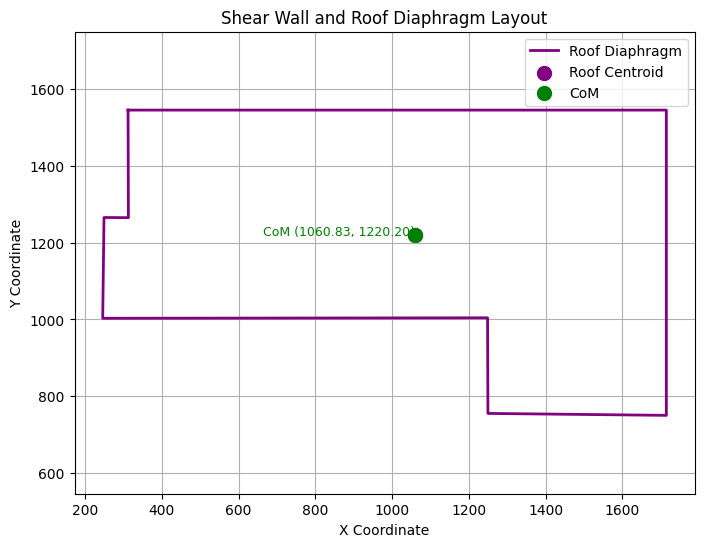

In [9]:
# import pathlib
# from shapely.geometry import MultiPolygon, Polygon
# import matplotlib.pyplot as plt
# from papermodels.paper import annotations, fdf, plot

import pathlib
from shapely.geometry import MultiPolygon
from shapely.affinity import translate
from papermodels.paper import annotations, fdf, plot
import matplotlib.pyplot as plt


import xlwings as xw
import pandas as pd
import matplotlib.pyplot as plt


from __future__ import annotations
from dataclasses import dataclass
import json
from typing import Any, Union, Optional
from papermodels.paper import annotations, fdf, plot
from papermodels.db.data_model import Annotation
from shapely.geometry import GeometryCollection, Polygon, Point
from shapely.ops import voronoi_diagram
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from shapely import wkt, voronoi_polygons

# Constants
DEFAULT_WALL_HEIGHT = 3.0  # Default height for all walls (in meters)
FDF_FILE = 'Roof_data_r9.fdf'  # FDF file for wall data
ROOF_WEIGHT_PER_AREA = 2.9  # Weight per unit area of the roof diaphragm (kPa)
NS_LINE_WEIGHT = 2.0  # Line weight for north-south walls
EW_LINE_WEIGHT = 3.0  # Line weight for east-west walls

# Functions
def read_walls_from_fdf(annots_by_diaphragm, line_weight_ns=NS_LINE_WEIGHT, line_weight_ew=EW_LINE_WEIGHT):
    """
    Reads wall data from annotations and separates them into NS and EW walls.
    
    Parameters:
    - annots_by_diaphragm: Annotations from the diaphragm FDF file.
    - line_weight_ns: Line weight for north-south walls.
    - line_weight_ew: Line weight for east-west walls.
    
    Returns:
    - ns_walls: List of NS wall data (lengths, x, y coordinates).
    - ew_walls: List of EW wall data (lengths, x, y coordinates).
    """
    ns_walls = []
    ew_walls = []

    # Filter for NS walls
    ns_annotations = annotations.filter_annotations(annots_by_diaphragm, {'line_weight': line_weight_ns})
    ns_shapes = annotations.annotations_to_shapely(ns_annotations)
    for shape in ns_shapes:
        if isinstance(shape, Polygon) and not shape.is_empty:  # Validate geometry
            length = shape.length
            x, y = shape.centroid.x, shape.centroid.y
            ns_walls.append({'length': length, 'x': x, 'y': y})

    # Filter for EW walls
    ew_annotations = annotations.filter_annotations(annots_by_diaphragm, {'line_weight': line_weight_ew})
    ew_shapes = annotations.annotations_to_shapely(ew_annotations)
    for shape in ew_shapes:
        if isinstance(shape, Polygon) and not shape.is_empty:  # Validate geometry
            length = shape.length
            x, y = shape.centroid.x, shape.centroid.y
            ew_walls.append({'length': length, 'x': x, 'y': y})

    return ns_walls, ew_walls



def calculate_wall_weights(walls, default_height, weight_per_unit_area=0.48):
    """
    Calculates wall weights using a default height.
    
    Parameters:
    - walls: List of wall data containing lengths.
    - default_height: Default height for all walls.
    - weight_per_unit_area: Weight per unit area (default is 0.48 kPa).
    
    Returns:
    - List of wall weights.
    """
    return [wall['length'] * default_height * weight_per_unit_area for wall in walls]

# # Read annotations from FDF
# project_dir = pathlib.Path.cwd()
# fdf_path = [project_dir / FDF_FILE]
# annots_by_diaphragm = annotations.filter_annotations(
#     fdf.read_annotations(fdf_path[0]), {}
# )


# Read annotations from FDF
project_dir = pathlib.Path.cwd()
fdf_path = [project_dir / FDF_FILE]
annots_by_diaphragm = fdf.read_annotations(fdf_path[0])

# Extract wall data
ns_walls, ew_walls = read_walls_from_fdf(annots_by_diaphragm)

# Continue with calculations...

# Extract wall data
# ns_walls, ew_walls = read_walls_from_fdf(annots_by_diaphragm)

# Calculate wall weights
ns_weights = calculate_wall_weights(ns_walls, DEFAULT_WALL_HEIGHT)
ew_weights = calculate_wall_weights(ew_walls, DEFAULT_WALL_HEIGHT)

# Extract wall centroids
ns_centroids = [(wall['x'], wall['y']) for wall in ns_walls]
ew_centroids = [(wall['x'], wall['y']) for wall in ew_walls]

# Process roof diaphragm data
roof_area_annotations = annotations.filter_annotations(annots_by_diaphragm, {'line_weight': 1.0})
roof_diaphragm = annotations.annotations_to_shapely(roof_area_annotations)

# Combine roof diaphragm polygons into a MultiPolygon
multi_polygon = MultiPolygon(roof_diaphragm)

# Calculate roof diaphragm centroid and weight
roof_centroid_x, roof_centroid_y = multi_polygon.centroid.x, multi_polygon.centroid.y
roof_area = multi_polygon.area
roof_weight = roof_area * ROOF_WEIGHT_PER_AREA

# Calculate center of mass (CoM) including roof diaphragm
total_weight = sum(ns_weights + ew_weights) + roof_weight
com_x = (sum(weight * x for weight, (x, _) in zip(ns_weights + ew_weights, ns_centroids + ew_centroids)) +
         roof_weight * roof_centroid_x) / total_weight
com_y = (sum(weight * y for weight, (_, y) in zip(ns_weights + ew_weights, ns_centroids + ew_centroids)) +
         roof_weight * roof_centroid_y) / total_weight



# Extract wall data
ns_walls, ew_walls = read_walls_from_fdf(annots_by_diaphragm)

# Validate extracted walls
if not ns_walls:
    print("No NS walls found. Check line_weight or FDF data.")
if not ew_walls:
    print("No EW walls found. Check line_weight or FDF data.")


# Visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Plot NS walls
for idx, wall in enumerate(ns_walls):
    x, y = wall['x'], wall['y']
    ax.plot([x, x], [y, y + wall['length']], color='red', linewidth=2, label='NS Wall' if idx == 0 else "")

# Plot EW walls
for idx, wall in enumerate(ew_walls):
    x, y = wall['x'], wall['y']
    ax.plot([x, x + wall['length']], [y, y], color='blue', linewidth=3, label='EW Wall' if idx == 0 else "")

# Plot Roof Diaphragm
for geom in multi_polygon.geoms:
    x, y = geom.exterior.xy
    ax.plot(x, y, color='purple', linewidth=2, label='Roof Diaphragm')

# Plot Roof Centroid
ax.scatter(roof_centroid_x, roof_centroid_y, color='purple', s=100, label='Roof Centroid')

# Plot CoM
ax.scatter(com_x, com_y, color='green', s=100, label='CoM')

# Annotate CoM
ax.text(com_x, com_y, f'CoM ({com_x:.2f}, {com_y:.2f})', fontsize=9, color='green', ha='right')

# Formatting
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Shear Wall and Roof Diaphragm Layout')
ax.legend()
ax.grid(True)
ax.axis('equal')

plt.show()



In [10]:
# extract all the roof and wall data and plot them together here

In [12]:
import pathlib
from shapely.geometry import MultiPolygon
from shapely.affinity import translate
from papermodels.paper import annotations, fdf, plot
import matplotlib.pyplot as plt


import xlwings as xw
import pandas as pd
import matplotlib.pyplot as plt


from __future__ import annotations
from dataclasses import dataclass
import json
from typing import Any, Union, Optional
from papermodels.paper import annotations, fdf, plot
from papermodels.db.data_model import Annotation
from shapely.geometry import GeometryCollection, Polygon, Point
from shapely.ops import voronoi_diagram
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from shapely import wkt, voronoi_polygons



def load_annotations(file_list: list[str], scale_factor: Optional[float] = None, labels: Optional[list[str]] = None) -> dict[str, list[Annotation]]:
    
    """
    Returns a dict whose keys are each file name in 'file_list' and values are a list
    of annotations found in the files. If 'scale_factor' is specified, the resulting
    annotation geometries are scaled by 'scale_factor'.
    'labels' - Labels to be used as dict keys for each file in 'file_list'
    
    """
    annot_data = {}
    for idx, file_name in enumerate(file_list):
        annots = fdf.read_annotations(file_name)
        if scale_factor is not None:
            annots = annotations.scale_annotations(annots, scale=scale_factor)
        if labels is not None:
            if len(labels) != len(file_list):
                raise ValueError(f"Length of labels must match length file list. {len(file_list)=}, {len(labels)=}")
            annot_data.update({labels[idx]: annots})
    return annot_data


FDF_FILE = 'Roof_data_r9.fdf'  # FDF file for wall data
# Read annotations from FDF
project_dir = pathlib.Path.cwd()
fdf_path = [project_dir / FDF_FILE]
annots_by_diaphragm = fdf.read_annotations(fdf_path[0])


annots_by_diaphragm = load_annotations(file_list = fdf_path, scale_factor=1/72 *(8*25.4)/100, labels=['diaphragm'])
annots_by_diaphragm


plot.plot_annotations(annots_by_diaphragm['diaphragm'], size=6, dpi=200)

opening_area_properties={'line_weight': 1.0}
for label, annots in annots_by_diaphragm.items():
    # panel_area_annots = annotations.filter_annotations(annots, panel_area_properties)
    opening_area_annots = annotations.filter_annotations(annots, opening_area_properties)

panel_area = annotations.annotations_to_shapely(opening_area_annots)
panel_area


# # Example: Replace with actual Shapely MultiPolygon data
# panel_area = MultiPolygon([
#     Polygon([(0, 0), (20, 0), (20, 10), (0, 10), (0, 0)]),  # Example polygon
# ])

# Combine all polygons into a MultiPolygon
multi_polygon = MultiPolygon(panel_area)

[Annotation(object_type='Polygon', vertices=[312.0, 1545.599, 1714.559, 1545.599, 1714.559, 750.24, 1249.68, 755.28, 1248.72, 1004.4, 246.0, 1003.2, 249.359, 1265.76, 312.96, 1265.28], page='0', text=None, line_color=(1.0, 0.0, 0.0), line_weight=1.0, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, -240.5, -744.74]),
 Annotation(object_type='Polygon', vertices=[312.0, 1545.599, 1714.559, 1545.599, 1714.559, 750.24, 1249.68, 755.28, 1248.72, 1004.4, 246.0, 1003.2, 249.359, 1265.76, 312.96, 1265.28], page='0', text=None, line_color=(1.0, 0.0, 0.0), line_weight=0.5, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, 0.0, 0.0]),
 Annotation(object_type='Line', vertices=[316.319, 1258.559, 316.319, 1545.598], page='0', text=None, line_color=(1.0, 0.0, 0.0), line_weight=2.0, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, -309.819

MultiPolygon Centroid: (29.94, 34.44)


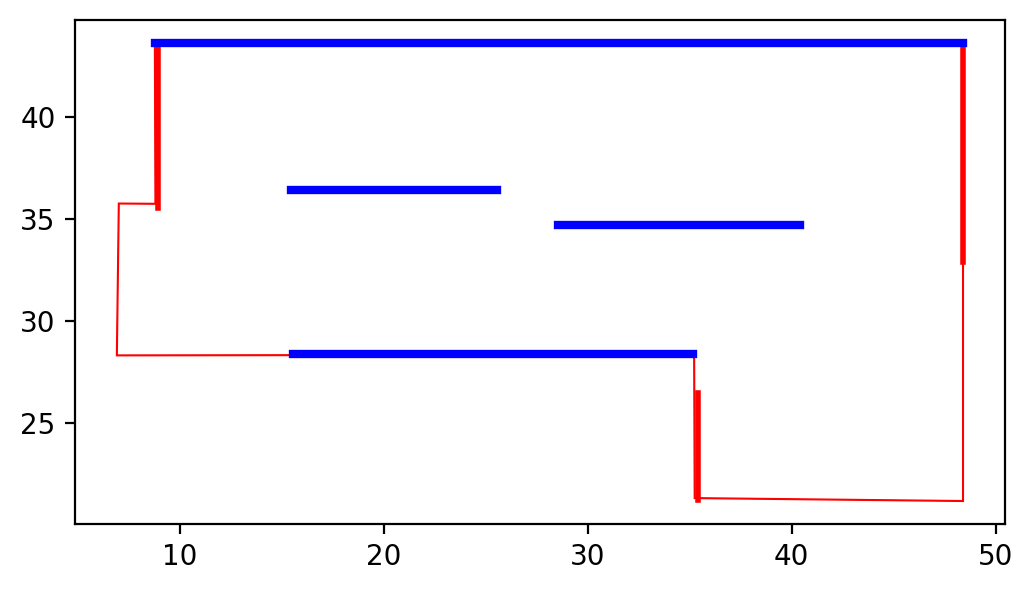